In [8]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from functools import partial
from typing import Callable, Iterable, Optional, Tuple, Union

import torch
from torch import nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
import math

In [13]:
# copy from hf transformers
class SchedulerType(Enum):
    LINEAR = "linear"
    COSINE = "cosine"
    COSINE_WITH_RESTARTS = "cosine_with_restarts"
    POLYNOMIAL = "polynomial"
    CONSTANT = "constant"
    CONSTANT_WITH_WARMUP = "constant_with_warmup"
    INVERSE_SQRT = "inverse_sqrt"
    REDUCE_ON_PLATEAU = "reduce_lr_on_plateau"
    COSINE_WITH_MIN_LR = "cosine_with_min_lr"
    WARMUP_STABLE_DECAY = "warmup_stable_decay"

In [14]:
def _get_constant_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int):
    # 如果current_step< num_warmup_steps,则一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1.0, num_warmup_steps))
    return 1.0

def get_constant_schedule_with_warmup(optimizer: Optimizer, num_warmup_steps: int, last_epoch: int = -1):
    """
    Create a schedule with a constant learning rate preceded by a warmup period during which the learning rate
    increases linearly between 0 and the initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    lr_lambda = partial(_get_constant_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps)
    # 创建init_lr的系数函数,最终lr为init_lr * lr_lambda, 即return [base_lr * lmbda(self.last_epoch) for lmbda, base_lr in zip(self.lr_lambdas, self.base_lrs)]
    return LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)


def _get_linear_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int, num_training_steps: int):
    # 1. 如果current_step< num_warmup_steps,则一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr 
    # 2. 如果current_step>num_warmup_steps,则线性减小到0(current_step=num_training_steps时)
    # Args:
    # optimizer ([`~torch.optim.Optimizer`]):
    #     The optimizer for which to schedule the learning rate.
    # num_warmup_steps (`int`):
    #     The number of steps for the warmup phase.
    # num_training_steps (`int`):
    #     The total number of training steps. 整个训练过程总共需要train的step次数
    # last_epoch (`int`, *optional*, defaults to -1):
    #     The index of the last epoch when resuming training.
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))


def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float=0.5
):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 如果current_step>num_warmup_steps,则使用cos学习率进行减小直到0，当然可以控制cos循环次数
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`float`, *optional*, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    # cos周期T=2*pi/w=1/(num_cycles*progress)
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) # 1/2*(1+cos(x))，即将cos范围调为0～1


def _get_cosine_with_hard_restarts_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: int=1
):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 如果current_step>num_warmup_steps,则使用cos学习率进行减小直到0，当然可以控制cos循环次数
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, with several hard restarts, after a warmup period during which it increases
    linearly between 0 and the initial lr set in the optimizer.
    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`int`, *optional*, defaults to 1):
            The number of hard restarts to use.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    if progress >= 1.0:
        return 0.0
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * ((float(num_cycles) * progress) % 1.0))))

def _get_polynomial_decay_schedule_with_warmup_lr_lambda(
    current_step: int,
    *,
    num_warmup_steps: int,
    num_training_steps: int,
    lr_end: float=1e-7,
    power: float=1.0,
    lr_init: int=1e-4,
):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 如果current_step>num_training_stpes, 则lr=lambda*lr_end = lr_end/lr_init*lr_init=lr_end
    # 3. 否则，从init_lr按多项式衰减到lr_end
    """
    Create a schedule with a learning rate that decreases as a polynomial decay from the initial lr set in the
    optimizer to end lr defined by *lr_end*, after a warmup period during which it increases linearly from 0 to the
    initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        lr_end (`float`, *optional*, defaults to 1e-7):
            The end LR.
        power (`float`, *optional*, defaults to 1.0):
            Power factor.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Note: *power* defaults to 1.0 as in the fairseq implementation, which in turn is based on the original BERT
    implementation at
    https://github.com/google-research/bert/blob/f39e881b169b9d53bea03d2d341b31707a6c052b/optimization.py#L37

    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    elif current_step > num_training_steps:
        return lr_end / lr_init  # as LambdaLR multiplies by lr_init, 最终的lr=lr/lr_end*lr_init=lr_end
    else:
        lr_range = lr_init - lr_end
        decay_steps = num_training_steps - num_warmup_steps
        pct_remaining = 1 - (current_step - num_warmup_steps) / decay_steps
        decay = lr_range * pct_remaining**power + lr_end # 注意：这里有一个power
        return decay / lr_init  # as LambdaLR multiplies by lr_init

def _get_inverse_sqrt_schedule_lr_lambda(current_step: int, *, num_warmup_steps: int, timescale: int = None):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 否则，从init_lr按1/sqrt(step)逆平方衰减
    """
    Create a schedule with an inverse square-root learning rate, from the initial lr set in the optimizer, after a
    warmup period which increases lr linearly from 0 to the initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        timescale (`int`, *optional*, defaults to `num_warmup_steps`):
            Time scale.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
    """
    # Note: this implementation is adapted from
    # https://github.com/google-research/big_vision/blob/f071ce68852d56099437004fd70057597a95f6ef/big_vision/utils.py#L930

    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    shift = timescale - num_warmup_steps
    decay = 1.0 / math.sqrt((current_step + shift) / timescale)
    return decay

def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, num_cycles: float=0.5, min_lr_rate: float = 0.0
):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 如果current_step>num_warmup_steps,则使用cos学习率进行减小直到min_lr_rate(而不是0)，当然可以控制cos循环次数
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to min_lr, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        num_cycles (`float`, *optional*, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
        min_lr (`float`, *optional*):
            The minimum learning rate to reach after the cosine schedule.
        min_lr_rate (`float`, *optional*):
            The minimum learning rate as a ratio of the initial learning rate. If set, `min_lr` should not be set.
    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
    factor = 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    factor = factor * (1 - min_lr_rate) + min_lr_rate
    return max(0, factor)

def _get_wsd_scheduler_lambda(
    current_step: int,
    *,
    num_warmup_steps: int,
    num_stable_steps: int,
    num_decay_steps: int,
    num_cycles: float=0.5,
    min_lr_ratio: float=0,
):
    # 1. 如果current_step< num_warmup_steps,则从0一直增长，直到1,此时lr=lambda*init_lr=1*init_lr=init_lr
    # 2. 如果current_step在[num_warmup_steps, num_warmup_steps+num_stable_steps]之间,则保持lr=init_lr不变
    # 2. 如果current_step>num_warmup_steps+num_stable_steps, 则使用cos学习率进行减小直到min_lr_rate(而不是0)，当然可以控制cos循环次数
    """
    Create a schedule with a learning rate that has three stages:
    1. linear increase from 0 to initial lr.
    2. constant lr (equal to initial lr).
    3. decrease following the values of the cosine function between the initial lr set in the optimizer to
       a fraction of initial lr.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_stable_steps (`int`):
            The number of steps for the stable phase.
        num_decay_steps (`int`):
            The number of steps for the cosine annealing phase.
        min_lr_ratio (`float`, *optional*, defaults to 0):
            The minimum learning rate as a ratio of the initial learning rate.
        num_cycles (`float`, *optional*, defaults to 0.5):
            The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
            following a half-cosine).
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    if current_step < num_warmup_steps + num_stable_steps:
        return 1.0
    if current_step < num_warmup_steps + num_stable_steps + num_decay_steps:
        progress = float(current_step - num_warmup_steps - num_stable_steps) / float(max(1, num_decay_steps))
        value = max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
        return (1.0 - min_lr_ratio) * value + min_lr_ratio
    return min_lr_ratio

In [54]:
num_training_steps=10000
num_warmup_steps = 1000

TYPE_TO_SCHEDULER_FUNCTION = {
    SchedulerType.LINEAR: partial(_get_linear_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps),
    SchedulerType.COSINE: partial(_get_cosine_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=0.5),
    SchedulerType.COSINE_WITH_RESTARTS: partial(_get_cosine_with_hard_restarts_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=2),
    SchedulerType.POLYNOMIAL: partial(_get_polynomial_decay_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, lr_end=1e-7, power=1.0, lr_init=1),
    SchedulerType.INVERSE_SQRT: partial(_get_inverse_sqrt_schedule_lr_lambda, num_warmup_steps=num_warmup_steps, timescale=num_warmup_steps),
    SchedulerType.COSINE_WITH_MIN_LR: partial(_get_cosine_schedule_with_warmup_lr_lambda, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=3, min_lr_rate=0.2),
    SchedulerType.WARMUP_STABLE_DECAY: partial(_get_wsd_scheduler_lambda, num_warmup_steps=num_warmup_steps, num_stable_steps=2000, num_decay_steps=3000, min_lr_ratio=0.1, num_cycles=1),
}

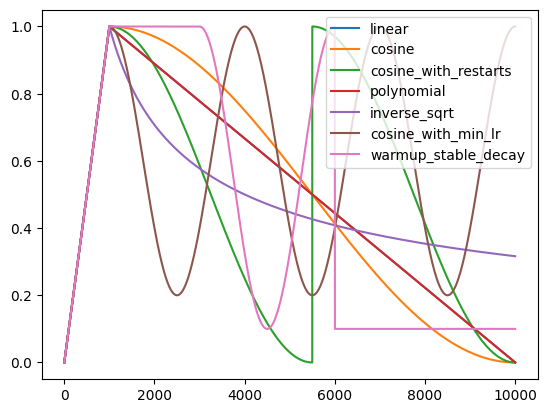

In [55]:

x=np.arange(0,num_training_steps)

for lr_name, lr_func in TYPE_TO_SCHEDULER_FUNCTION.items():
    f=np.frompyfunc(lambda step: lr_func(step),1,1) # 在400时取最大值
    y=f(x)
    plt.plot(x,y, label=f'{lr_name.name.lower()}')

plt.legend()
plt.savefig('lr_scheduler')